<a href="https://colab.research.google.com/github/zimplackster/-B3-Time-Series/blob/main/%5BB3%5D_Forecast_%7C_BMGB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bibliotecas e Funções

In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib gspread==5.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 31.5 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.2.0
    Uninstalling gspread-6.2.0:
      Successfully uninstalled gspread-6.2.0
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.164.0
    Uninstalling google-api-python-client-2.164.0:
      Successfully uninstalled google-api-python-client-2.164.0


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from dateutil.relativedelta import relativedelta
from google.colab import auth
import gspread
from google.auth import default

In [ ]:
Treino = False

#Funções do Desenvolvedor

##Datas

In [ ]:
if Treino == True:
  #Definição de Data
  start_date = "2000-01-01"
  end_date   = datetime.now().strftime("%Y-%m-%d")
  #Data para modelagem
  end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
  filt_date   = (end_date_dt - relativedelta(months=6)).strftime("%Y-%m-%d")
  end_date    = filt_date

else:
  start_date = "2000-01-01"
  end_date   = datetime.now().strftime("%Y-%m-%d")
   #Data para modelagem
  end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
  filt_date   = end_date





In [ ]:
print(start_date, end_date, filt_date)

2000-01-01 2025-04-06 2025-04-06


##Lista de ativos



In [ ]:
ativos = [
    # Holdings Financeiras
    "ITSA4",  # Itaúsa
    "BBSE3",  # BB Seguridade (ligada ao BB)
    "BRIV4",  # BR Insurance
    "BRGE11", # Energisa Investimentos (holding do setor elétrico, mas inclui financeira)
    # Bancos
    "BBAS3",  # Banco do Brasil
    "ITUB4",  # Itaú Unibanco
    "BBDC3",  # Bradesco ON
    "BBDC4",  # Bradesco PN
    "SANB11", # Santander Brasil (units)
    "BPAC11", # BTG Pactual (units)
    "BPAN4",  # Banco Pan
    "ABCB4",  # Banco ABC Brasil
    "BRSR6",  # Banrisul
    "BMGB4",  # Banco BMG
    "BMEB4",  # Banco Mercantil do Brasil
    "PINE4",  # Banco Pine
    "BAZA3",  # Banco da Amazônia
    "BNBR3",  # Banco do Nordeste
    "BEES3",  # Banestes ON
    "BEES4",  # Banestes PN
]

##Importando Ações B3

In [ ]:
def baixar_ativo_b3(ativo, start_date, end_date):
    nome_df = f"df_{ativo.lower()}"
    df = yf.download(f"{ativo}.SA", start=start_date, end=end_date)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)
    df.columns.name = None

    df = df.reset_index()
    df['Date']  = pd.to_datetime(df['Date'])
    df['Ativo'] = ativo.upper()

    globals()[nome_df] = df
    return df

##Looping de importação dos ativos

In [ ]:
for ativo in ativos:
    df_completo = baixar_ativo_b3(ativo, start_date, end_date)

    # Cria DataFrame filtrado (base de treino)
    df_filtrado = df_completo[df_completo['Date'] <= filt_date]

    # Define nomes dinamicamente
    globals()[f"df_{ativo.lower()}_filt"] = df_filtrado

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
del df_completo
del df_filtrado

##Lista com os Dataframes

In [ ]:
dfs_gerados = [nome for nome, obj in globals().items() if nome.startswith("df_") and isinstance(obj, pd.DataFrame)]
dfs_treino  = [nome for nome, obj in globals().items() if nome.endswith("_filt") and isinstance(obj, pd.DataFrame)]
dfs_modelo  = [nome for nome, obj in globals().items() if not nome.endswith("_filt") and isinstance(obj, pd.DataFrame)]

In [ ]:
print("DFs Gerados:", dfs_gerados)
print("DFs Treino:", dfs_treino)
print("DFs Modelo:", dfs_modelo)

DFs Gerados: ['df_itsa4', 'df_itsa4_filt', 'df_bbse3', 'df_bbse3_filt', 'df_briv4', 'df_briv4_filt', 'df_brge11', 'df_brge11_filt', 'df_bbas3', 'df_bbas3_filt', 'df_itub4', 'df_itub4_filt', 'df_bbdc3', 'df_bbdc3_filt', 'df_bbdc4', 'df_bbdc4_filt', 'df_sanb11', 'df_sanb11_filt', 'df_bpac11', 'df_bpac11_filt', 'df_bpan4', 'df_bpan4_filt', 'df_abcb4', 'df_abcb4_filt', 'df_brsr6', 'df_brsr6_filt', 'df_bmgb4', 'df_bmgb4_filt', 'df_bmeb4', 'df_bmeb4_filt', 'df_pine4', 'df_pine4_filt', 'df_baza3', 'df_baza3_filt', 'df_bnbr3', 'df_bnbr3_filt', 'df_bees3', 'df_bees3_filt', 'df_bees4', 'df_bees4_filt']
DFs Treino: ['df_itsa4_filt', 'df_bbse3_filt', 'df_briv4_filt', 'df_brge11_filt', 'df_bbas3_filt', 'df_itub4_filt', 'df_bbdc3_filt', 'df_bbdc4_filt', 'df_sanb11_filt', 'df_bpac11_filt', 'df_bpan4_filt', 'df_abcb4_filt', 'df_brsr6_filt', 'df_bmgb4_filt', 'df_bmeb4_filt', 'df_pine4_filt', 'df_baza3_filt', 'df_bnbr3_filt', 'df_bees3_filt', 'df_bees4_filt']
DFs Modelo: ['df_itsa4', 'df_bbse3', 'df_bri

In [ ]:
dfs_treino = ['df_itsa4_filt', 'df_bbse3_filt', 'df_briv4_filt', 'df_brge11_filt', 'df_bbas3_filt', 'df_itub4_filt', 'df_bbdc3_filt', 'df_bbdc4_filt', 'df_sanb11_filt',
             'df_bpac11_filt', 'df_bpan4_filt', 'df_abcb4_filt', 'df_brsr6_filt', 'df_bmgb4_filt', 'df_bmeb4_filt', 'df_pine4_filt', 'df_baza3_filt', 'df_bnbr3_filt',
             'df_bees3_filt', 'df_bees4_filt']

In [ ]:
dfs_modelo  = ['df_itsa4', 'df_bbse3', 'df_briv4', 'df_brge11', 'df_bbas3', 'df_itub4', 'df_bbdc3', 'df_bbdc4', 'df_sanb11', 'df_bpac11', 'df_bpan4', 'df_abcb4',
               'df_brsr6', 'df_bmgb4', 'df_bmeb4', 'df_pine4', 'df_baza3', 'df_bnbr3', 'df_bees3', 'df_bees4']

#Processamento

##Preparação dos DataFrames

In [ ]:
def preparar_modelo_individual(nome_df, janela_mm=34):
    if nome_df in globals():
        df_original = globals()[nome_df]

        if all(col in df_original.columns for col in ['Date', 'Close', 'Volume']):
            df_model = df_original[['Date', 'Close', 'Volume']].copy()
            df_model = df_model.dropna()
            df_model['Date'] = pd.to_datetime(df_model['Date'])
            df_model = df_model.sort_values('Date')
            df_model['y'] = df_model['Close'].rolling(window=janela_mm, center=True).mean()
            df_model = df_model.dropna()
            df_model = df_model[['Date', 'Close', 'y', 'Volume']].rename(columns={'Date': 'ds'})

            ajuste = df_model['Close'].iloc[-1] - df_model['y'].iloc[-1]
            df_model['y'] += ajuste

            nome_saida = f"{nome_df}_model_treino"
            globals()[nome_saida] = df_model
            print(f"✅ Modelo preparado: {nome_saida}")
        else:
            print(f"⚠️ {nome_df} não possui as colunas necessárias.")
    else:
        print(f"❌ {nome_df} não encontrado no ambiente.")


##Turning Points

In [ ]:
def detectar_turning_points_individual(nome_df_modelo, ordem=21):
    if nome_df_modelo in globals():
        df_model = globals()[nome_df_modelo].copy()

        try:
            df_turn = df_model.sort_values('ds').reset_index(drop=True)
            close_array = df_turn['Close'].values

            max_idx = argrelextrema(close_array, np.greater_equal, order=ordem)[0]
            min_idx = argrelextrema(close_array, np.less_equal, order=ordem)[0]

            df_turn['Turning_Point'] = 'none'
            df_turn.iloc[max_idx, df_turn.columns.get_loc('Turning_Point')] = 'max'
            df_turn.iloc[min_idx, df_turn.columns.get_loc('Turning_Point')] = 'min'

            turning_points = df_turn[df_turn['Turning_Point'] != 'none']
            turning_points_list = turning_points['ds'].tolist()

            nome_base = nome_df_modelo.replace('df_', '').replace('_filt_model_treino', '').replace('_model_treino', '')
            nome_saida = f"turning_points_list_{nome_base}_model_treino"

            globals()[nome_saida] = turning_points_list
            print(f"✅ Turning points gerados: {nome_saida} ({len(turning_points_list)} pontos)")

        except Exception as e:
            print(f"❌ Erro ao processar {nome_df_modelo}: {e}")
    else:
        print(f"❌ DataFrame {nome_df_modelo} não encontrado.")


###Visualização do Turning Points

In [ ]:
def plot_turning_points(df_model_treino, turning_points_list):
    plt.figure(figsize=(14, 6))

    # Plot linha base
    plt.plot(df_model_treino['ds'], df_model_treino['Close'], label='Preço Real', color='blue')

    # Adiciona os pontos de turning
    pontos = df_model_treino[df_model_treino['ds'].isin(turning_points_list)]
    plt.scatter(pontos['ds'], pontos['Close'], color='orange', label='Turning Points', zorder=5)

    plt.title("Turning Points no Preço Real")
    plt.xlabel("Data")
    plt.ylabel("Preço")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#Modelagem

##Modelo Prohet

In [ ]:
def treinar_modelo_prophet_individual(nome_df_modelo, dias_a_prever=180, params_prophet=None):
    if nome_df_modelo in globals():
        df_model = globals()[nome_df_modelo]

        nome_base = nome_df_modelo.replace('df_', '').replace('_filt_model_treino', '').replace('_model_treino', '')
        nome_lista_turning = f"turning_points_list_{nome_base}_model_treino"

        if nome_lista_turning in globals():
            turning_points_list = globals()[nome_lista_turning]

            try:
                # Parâmetros padrão do Prophet
                default_params = {
                    'growth': 'linear',
                    'daily_seasonality': True,
                    'weekly_seasonality': True,
                    'yearly_seasonality': True,
                    'seasonality_mode': 'additive',
                    'changepoint_prior_scale': 0.3,
                    'seasonality_prior_scale': 10,
                    'holidays_prior_scale': 10.0,
                    'interval_width': 0.99,
                    'changepoints': turning_points_list
                }

                # Sobrescreve os parâmetros se fornecidos
                if params_prophet:
                    default_params.update(params_prophet)

                # Cria o modelo
                model = Prophet(**default_params)
                model.add_seasonality(name='monthly', period=30.5, fourier_order=25)
                model.add_seasonality(name='quarterly', period=91.25, fourier_order=13)
                model.add_regressor('Volume')

                # Treina
                model_fit = model.fit(df_model)

                # Gera datas futuras e previsão
                future = model.make_future_dataframe(periods=dias_a_prever)
                future = future.merge(df_model[['ds', 'Volume']], on='ds', how='left')
                future['Volume'] = future['Volume'].ffill()

                forecast = model.predict(future)

                # Salva no ambiente
                nome_modelo = f"prophet_model_{nome_base}"
                nome_forecast = f"forecast_{nome_base}"
                globals()[nome_modelo] = model_fit
                globals()[nome_forecast] = forecast

                print(f"✅ Modelo treinado: {nome_modelo}")
                print(f"📈 Forecast gerado: {nome_forecast} ({len(forecast)} linhas)")

            except Exception as e:
                print(f"❌ Erro ao treinar modelo: {e}")
        else:
            print(f"⚠️ Lista de turning points não encontrada: {nome_lista_turning}")
    else:
        print(f"❌ DataFrame não encontrado: {nome_df_modelo}")


#Modelo


#Unindo a previsão - com dado real

In [ ]:
def gerar_forecasts_e_comparar(dfs_model_treino, periodo=180):
    for nome_df in dfs_model_treino:
        if nome_df in globals():
            df_model = globals()[nome_df]
            nome_base = nome_df.replace('df_', '').replace('_filt_model_treino', '').replace('_model_treino', '')
            nome_modelo = f"prophet_model_{nome_base}"
            nome_df_full = f"df_{nome_base}"

            if nome_modelo in globals() and nome_df_full in globals():
                model_fit = globals()[nome_modelo]
                df_full = globals()[nome_df_full]

                # Criar DataFrame futuro
                future = model_fit.make_future_dataframe(periods=periodo)
                future = future.merge(df_full[['Date', 'Volume']], how='left', left_on='ds', right_on='Date')
                future.drop(columns=['Date'], inplace=True)

                # Preencher Volume ausente com a média da série histórica
                if 'Volume' in future.columns:
                    media_volume = df_full['Volume'].mean()
                    future['Volume'].fillna(media_volume, inplace=True)

                # Previsão
                forecast = model_fit.predict(future)

                # Unir previsão com dados reais
                df_comparado = pd.merge(
                    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                    df_full[['Date', 'Close']],
                    how='left',
                    left_on='ds',
                    right_on='Date'
                )

                df_comparado['Ativo'] = nome_base.upper()

                # Salvar com nome customizado
                nome_forecast = f"df_forecast_{nome_base}"
                globals()[nome_forecast] = df_comparado

                print(f"✅ Forecast gerado e unido com df_{nome_base}: {nome_forecast}")
            else:
                print(f"⚠️ Modelo ou DataFrame full não encontrado para: {nome_base}")
        else:
            print(f"❌ DataFrame de treino não encontrado: {nome_df}")



#Analisando previsão

In [ ]:
def gerar_df_real_previsto(ativo):
    try:
        nome_forecast = f"forecast_{ativo}"
        nome_df_real = f"df_{ativo}"

        if nome_forecast not in globals():
            print(f"❌ Forecast não encontrado: {nome_forecast}")
            return
        if nome_df_real not in globals():
            print(f"❌ Dados reais não encontrados: {nome_df_real}")
            return

        forecast = globals()[nome_forecast][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        forecast.rename(columns={'ds': 'Date', 'yhat': 'Close_Predict',
                                 'yhat_lower': 'Close_Predict_Lower',
                                 'yhat_upper': 'Close_Predict_Upper'}, inplace=True)

        df_real = globals()[nome_df_real].copy()
        df_real['Date'] = pd.to_datetime(df_real['Date'])

        df_real_previsto = pd.merge(forecast, df_real, on='Date', how='left')

        df_real_previsto['Diff'] = df_real_previsto['Close'] - df_real_previsto['Close_Predict']
        df_real_previsto['Diff_Perc'] = (df_real_previsto['Diff'] / df_real_previsto['Close']) * 100

        # Verifica se ficou fora do intervalo de confiança
        df_real_previsto['Fora_do_Intervalo'] = (
            (df_real_previsto['Close'] < df_real_previsto['Close_Predict_Lower']) |
            (df_real_previsto['Close'] > df_real_previsto['Close_Predict_Upper'])
        )

        nome_saida = f"df_real_previsto_{ativo}"
        globals()[nome_saida] = df_real_previsto

        print(f"✅ DataFrame gerado: {nome_saida} ({len(df_real_previsto)} linhas)")
    except Exception as e:
        print(f"❌ Erro ao gerar df_real_previsto para {ativo}: {e}")


#Execução

##Ativo: BMGB4

###Parâmetros

In [ ]:
# Nome do DataFrame original
nome_df = 'df_bmgb4'

# Etapa 1: Preparar modelo com média móvel de 21 dias
preparar_modelo_individual(nome_df, janela_mm=13)

# Etapa 2: Detectar turning points com ordem 13
detectar_turning_points_individual(f"{nome_df}_model_treino", ordem=21)


# # Etapa 3: Treinar modelo Prophet com parâmetros customizados
# params = {
#     'changepoint_prior_scale': 0.3,
#     'seasonality_prior_scale': 10,
#     'interval_width': 0.99
# }

# Etapa 3: Treinar modelo Prophet com parâmetros customizados
params = {
     'changepoint_prior_scale': 0.02,
     'seasonality_prior_scale': 10,
     'interval_width': 0.99
      }

✅ Modelo preparado: df_bmgb4_model_treino
✅ Turning points gerados: turning_points_list_bmgb4_model_treino (49 pontos)


###Prophet

In [ ]:
treinar_modelo_prophet_individual(f"{nome_df}_model_treino", dias_a_prever=180, params_prophet=params)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qfkehq7/q26vve9f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9qfkehq7/r7xfe3qq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=596', 'data', 'file=/tmp/tmp9qfkehq7/q26vve9f.json', 'init=/tmp/tmp9qfkehq7/r7xfe3qq.json', 'output', 'file=/tmp/tmp9qfkehq7/prophet_model3ht2tlru/prophet_model-20250406224737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Modelo treinado: prophet_model_bmgb4
📈 Forecast gerado: forecast_bmgb4 (1497 linhas)


###Unindo com o dado real

In [ ]:
gerar_df_real_previsto("bmgb4")

✅ DataFrame gerado: df_real_previsto_bmgb4 (1497 linhas)


#Plot | Modelo de Treino

In [ ]:
import plotly.graph_objects as go

def plot_previsao_com_intervalo_plotly(df_real_previsto):
    fig = go.Figure()

    # Linha da Previsão
    fig.add_trace(go.Scatter(
        x=df_real_previsto['Date'],
        y=df_real_previsto['Close_Predict'],
        mode='lines',
        name='Previsão (yhat)',
        line=dict(color='gray')
    ))

    # Linha do Limite Superior
    fig.add_trace(go.Scatter(
        x=df_real_previsto['Date'],
        y=df_real_previsto['Close_Predict_Upper'],
        mode='lines',
        name='Limite Superior',
        line=dict(color='red')
    ))

    # Linha do Limite Inferior
    fig.add_trace(go.Scatter(
        x=df_real_previsto['Date'],
        y=df_real_previsto['Close_Predict_Lower'],
        mode='lines',
        name='Limite Inferior',
        line=dict(color='green')
    ))

    # Linha do Preço Real
    fig.add_trace(go.Scatter(
        x=df_real_previsto['Date'],
        y=df_real_previsto['Close'],
        mode='lines',
        name='Preço Real',
        line=dict(color='blue')
    ))

    # Layout e título
    fig.update_layout(
        title="Preço Real vs Previsão do Modelo Prophet",
        xaxis_title="Data",
        yaxis_title="Preço",
        legend=dict(x=0, y=1),
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()


In [ ]:
plot_previsao_com_intervalo_plotly(df_real_previsto_bmgb4)

#Validando dado | Regressão entre os dados

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import numpy as np

# Remove valores nulos (caso existam)
df_valid = df_real_previsto_bmgb4.dropna(subset=['Close', 'Close_Predict'])

# X e Y
X = df_valid['Close'].values.reshape(-1, 1)
y = df_valid['Close_Predict'].values

# Correlação de Pearson
correlacao, _ = pearsonr(df_valid['Close'], df_valid['Close_Predict'])
print(f"📌 Correlação de Pearson: {correlacao:.4f}")

# Regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

print(f"🧮 Coeficiente angular (slope): {modelo.coef_[0]:.4f}")
print(f"📍 Intercepto (bias): {modelo.intercept_:.4f}")

📌 Correlação de Pearson: 0.9430
🧮 Coeficiente angular (slope): 0.8518
📍 Intercepto (bias): 0.3791


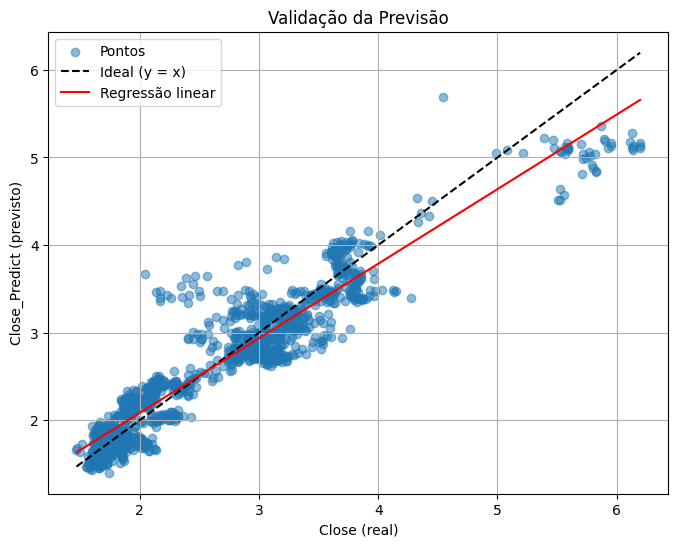

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_valid['Close'], df_valid['Close_Predict'], alpha=0.5, label='Pontos')

# Linha de identidade (y=x)
x_vals = np.linspace(df_valid['Close'].min(), df_valid['Close'].max(), 100)
plt.plot(x_vals, x_vals, '--', color='black', label='Ideal (y = x)')

# Linha da regressão
y_pred = modelo.predict(x_vals.reshape(-1, 1))
plt.plot(x_vals, y_pred, color='red', label='Regressão linear')

plt.xlabel('Close (real)')
plt.ylabel('Close_Predict (previsto)')
plt.legend()
plt.grid(True)
plt.title('Validação da Previsão')
plt.show()


#Exportando dado

In [ ]:
if Treino == False:
  auth.authenticate_user()
  creds, _ = default()
  gc = gspread.authorize(creds)

In [ ]:
if Treino == False:
  planilha_url = 'https://docs.google.com/spreadsheets/d/1ccQxkw3LSRlHlcb2bbUMiDrkbqkC_V286l_u111AZRI'
  nome_aba = 'BMGB4'

In [ ]:
if Treino == False:
  try:
   planilha = gc.open_by_url(planilha_url)
   aba = planilha.worksheet(nome_aba)
  except gspread.exceptions.WorksheetNotFound:
   aba = planilha.add_worksheet(title=nome_aba, rows="1000", cols="20")

In [ ]:
if Treino == False:
  df_export = df_real_previsto_bmgb4.copy()
  df_export['Date'] = df_export['Date'].dt.strftime('%Y-%m-%d')
  df_export['Ativo'] = nome_aba.upper()
  df_export['Setor'] = setor.upper()
  df_export = df_export.replace([np.inf, -np.inf, np.nan], '')

In [ ]:
if Treino == False:
  valores = [df_export.columns.tolist()] + df_export.values.tolist()

In [ ]:
if Treino == False:
  aba.clear()
  aba.update(valores)
  print(f"✅ Dados exportados para a aba '{nome_aba}' da planilha!")